In [1]:
import torch
from torch import Tensor

from sbi.analysis import pairplot
from sbi.inference import NPE, FMPE, SNPE, VIPosterior, simulate_for_sbi, NPE_A
from sbi.utils import BoxUniform
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)

from GP_dataloader import *

import argparse


inference_method = 'FMPE'
multi_round = False if inference_method == 'FMPE' else True
num_sims = 1000
sim_id = 700
num_rounds = 3


param_names, fiducial_values, maxdiff, minVal, maxVal = getParamsFiducial()


prior = BoxUniform(low=Tensor(minVal), high=Tensor(maxVal))
simulator = lambda x: getProfilesParamsTensor(x, filterType='CAP', ptype='gas')[1]

theta_true =  torch.tensor(getParams(777), dtype=torch.float32) # prior.sample((1,))
# generate our observation
x_obs = simulator(theta_true)


# Set up the inference method
if inference_method == "FMPE":
    inference = FMPE(prior=prior)
elif inference_method == "NPE":
    inference = NPE(prior=prior)
elif inference_method == "SNPE":
    inference = SNPE(prior=prior)

if multi_round:
    posteriors = []
    proposal = prior
    for r in range(num_rounds):
        theta, x = simulate_for_sbi(simulator, proposal, num_simulations=num_sims)
        inference = inference.append_simulations(theta, x)
        final_round = r == num_rounds - 1
        density_estimator = inference.train(final_round=final_round)
        posterior = inference.build_posterior(density_estimator)
        posteriors.append(posterior)
        proposal = posterior.set_default_x(x_obs)
else:
    theta = prior.sample((num_sims,))
    x = simulator(theta)
    inference.append_simulations(theta, x).train()
    posterior = inference.build_posterior()

/global/u1/l/lindajin/virtualenvs/env1/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/global/u1/l/lindajin/virtualenvs/env1/lib/python3.11/site-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.6.1 is installed, but it is not compatible with the installed jaxlib version 0.7.1, so it will not be used.
  warnings.warn(


Read 35 parameters from data/SB35_param_minmax.csv
Getting gas profiles with CAP filter given parameters...
Getting gas profiles with CAP filter for 1 simulations...
Finished getting profiles in 1 simulations.


TypeError: len() of unsized object

In [ ]:
# Convert to VI posterior
vi_posterior = VIPosterior(
    potential_fn=posterior.potential_fn,  # or potential_
    prior=prior,
)

vi_posterior = vi_posterior.set_default_x(x_obs)

# Train the VI approximation
vi_posterior.train(
    x=x_obs,
    num_iterations=1000,  # adjust based on convergence
    learning_rate=1e-3,
    show_progress_bars=True
)

# Now sampling is much faster
samples = vi_posterior.sample((1000,)) 


%|          | 0/2000 [00:00<?, ?it/s]
mup phase, this may take a few seconds...:   0%|          | 0/2000 [00:00<?, ?it/s]

In [10]:
samples = posterior.sample((1000,),x=x_obs)

Drawing 1000 posterior samples: 1635it [00:00, 86254.79it/s]            


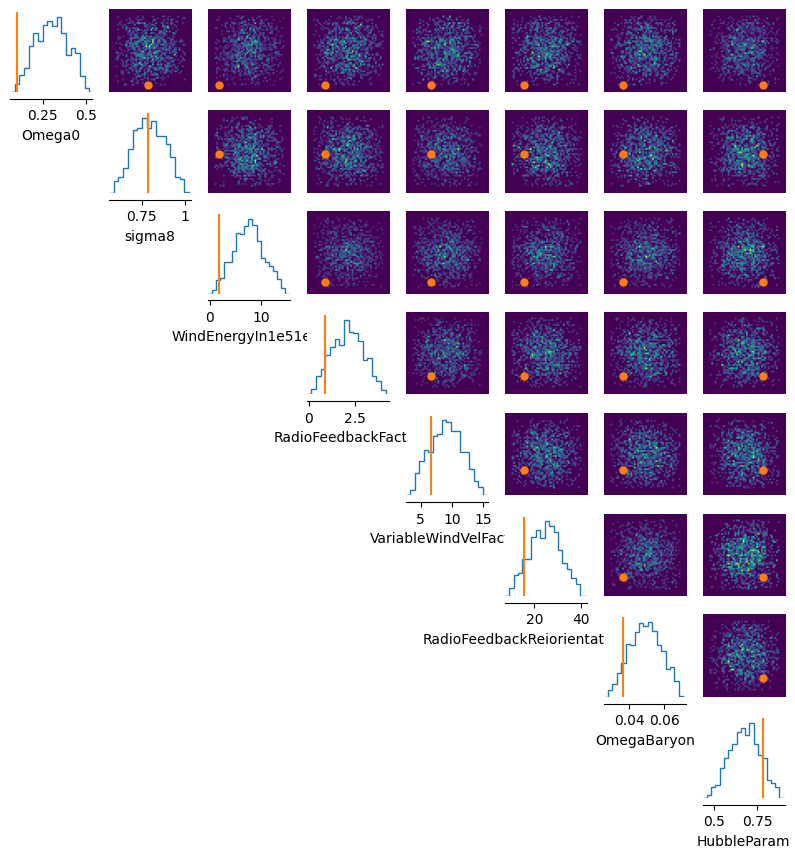

In [12]:
pairplot(samples[:,:8],
         points=theta_true[:8].unsqueeze(0),
         figsize=(10, 10),
         labels=param_names[:8]);

In [19]:
from sbi.inference import MCMCPosterior

mcmc_posterior = MCMCPosterior(
    potential_fn=posterior.potential_fn,
    proposal=prior,
    theta_transform=getattr(posterior, '_theta_transform', None)
)

samples = mcmc_posterior.sample(
    sample_shape=(1000,),  # or just (1000,)
    x=x_obs,
    num_chains=4,
    thin=1,
    warmup_steps=100,
    show_progress_bars=True
)

Running vectorized MCMC with 4 chains:   0%|          | 0/1600 [00:00<?, ?it/s]

KeyboardInterrupt: 

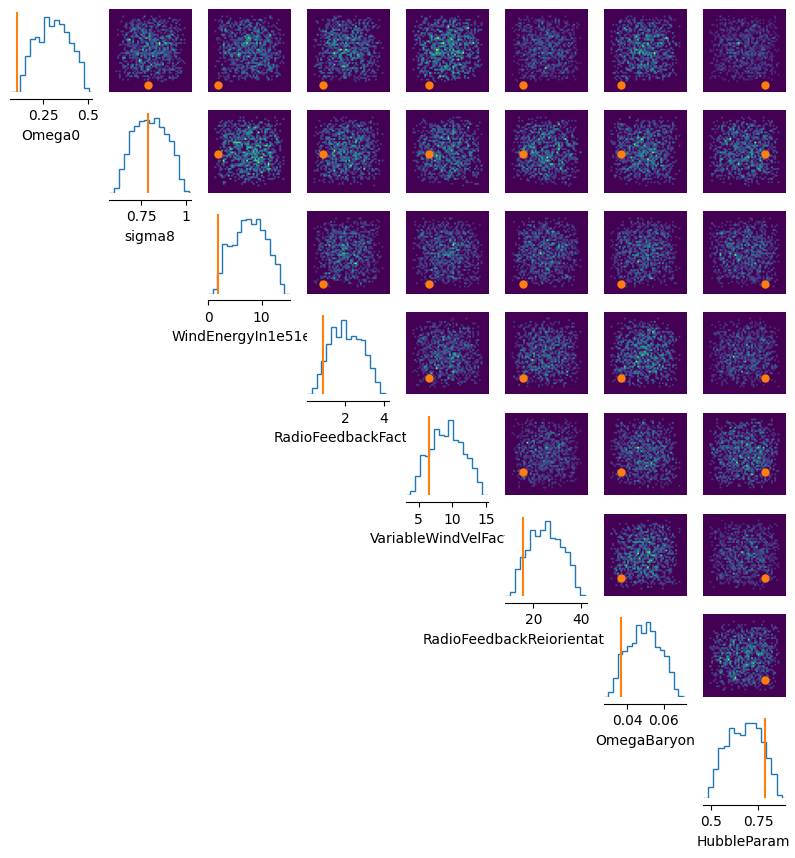

In [14]:
pairplot(samples[:,:8],
         points=theta_true[:8].unsqueeze(0),
         figsize=(10, 10),
         labels=param_names[:8]);